# Index Buy and Hold - Short MA vs Long MA

## Introduction

We will evaluate the following strategy:  

**QQQ Buy and Hold Short MA vs Long MA**: 

While the short MA is above the long hold the ETF.   
When the short MA drops below the long MA, sell it and buy it back when it crosses back above it. 

## Setup

In [60]:
import os
from datetime import datetime
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)

import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

%matplotlib widget
# inline is the old interface

## Index Buy and Hold short MA vs long MA

### Run backtest

In [61]:
import backfire as bf 

In [62]:
class ShortMAAboveLongMA(bf.Signal): 
    def __init__(self, short_MA, long_MA): 
        super().__init__(f"{str(short_MA)}dMAAbove{str(long_MA)}MA", env)
        
    def __call__(self, ohlcv): 
        ohlcv['ma' + str(long_MA)] = self.ma(ohlcv, long_MA)
        ohlcv['ma' + str(short_MA)]  = self.ma(ohlcv, short_MA)
        ohlcv['above'] = ohlcv['ma' + str(short_MA)] >= ohlcv['ma' + str(long_MA)]
        # ohlcv.to_csv(os.path.join(f"out_index_buy_hold_{str(short_MA)}MAvs{str(long_MA)}MA", f"{str(short_MA)}ma_above_{str(long_MA)}ma.csv"))
        ohlcv.to_csv(os.path.join(self.env.out_dir, f"{str(short_MA)}ma_above_{str(long_MA)}ma.csv"))
        
        return ohlcv.above
    
class ShortMABelowLongMA(bf.Signal): 
    def __init__(self, short_MA, long_MA): 
        super().__init__(f"{str(short_MA)}dMABelow{str(long_MA)}MA", env)
        
    def __call__(self, ohlcv): 
        ohlcv['ma' + str(long_MA)] = self.ma(ohlcv, long_MA)
        ohlcv['ma' + str(short_MA)]  = self.ma(ohlcv, short_MA)
        ohlcv['below'] = ohlcv['ma' + str(short_MA)] < ohlcv['ma' + str(long_MA)]
        ohlcv.to_csv(os.path.join(self.env.out_dir, f"{str(short_MA)}ma_below_{str(long_MA)}ma.csv"))
        
        return ohlcv.below
        

In [63]:
import backfire as bf

short_MA = 50 # days
long_MA = 150 # days

ticker = 'QQQ' # '^IXIC_1990'
name = f"Index_BuyAndHold_{str(short_MA)}MAvs{str(long_MA)}MA"
from_date = '2000-01-01' # '2013-03-01' # '1999-06-01' # "1990-01-01"
#dir_name = f"out_index_buy_hold_{str(short_MA)}MAvs{str(long_MA)}MA"
out_dir = f"out_index_buy_hold_shortMAvslongMA_exp"


env = bf.Environment(md=r"../md/daily", out_dir=out_dir)
entry_signal = ShortMAAboveLongMA(short_MA=short_MA, long_MA=long_MA)
exit_signal = ShortMABelowLongMA(short_MA=short_MA, long_MA=long_MA) 
risk_management = bf.OpenProtectiveStop(stop_loss=0.07, take_profit_threshold=3.0, trailing_stop_period=0)
risk_management = bf.NoRiskManagement()
#position_management = bf.PositionManagement(initial_position=100000, policy="fixed_fraction", fraction=1.0)

s = bf.SignalDrivenStrategy(
    env=env,
    entry_signal=entry_signal,
    exit_signal=exit_signal,
    risk_management=risk_management,
    position_management=position_management,
    name=name)
s.backtest(ticker=ticker, from_date=from_date)

print("Backtest done.")

Backtest done.


### Visualize signals and positions

In [64]:
df = pd.read_csv(os.path.join(out_dir, f"pos_{ticker}_{name}.csv"),index_col=0,parse_dates=True)
df[str(short_MA) + 'dSMA'] = df.C.rolling(short_MA, min_periods=short_MA).mean()
df[str(long_MA) + 'dSMA'] = df.C.rolling(long_MA,min_periods=long_MA).mean()

In [65]:
# from_to = ['2020-05-01', '2021-03-01']
# from_to = [datetime.strptime(x, "%Y-%m-%d").date() for x in from_to]
# df = df.loc[from_to[0]:from_to[1]]
df.tail()

O      H      L      C         V   es     xs  pos       cash  \
Date                                                                           
2022-06-13 279.75 282.34 274.53 275.41  94442000 0.00 275.41 0.00 508,156.97   
2022-06-14 277.66 278.66 273.34 275.91  64697500 0.00 275.91 0.00 508,156.97   
2022-06-15 279.42 286.83 276.61 282.80  86051400 0.00 282.80 0.00 508,156.97   
2022-06-16 275.59 276.06 269.28 271.39  81910300 0.00 271.39 0.00 508,156.97   
2022-06-17 272.18 277.19 270.51 274.69  82594000 0.00 274.69 0.00 508,156.97   

           action memo  buy_price  trailing_stop    balance  \
Date                                                          
2022-06-13    NaN  NaN        NaN         305.69 508,156.97   
2022-06-14    NaN  NaN        NaN         302.32 508,156.97   
2022-06-15    NaN  NaN        NaN         299.09 508,156.97   
2022-06-16    NaN  NaN        NaN         296.77 508,156.97   
2022-06-17    NaN  NaN        NaN         292.47 508,156.97   

            unrealized_CumMax  unrealized_dd  unrealized_dd_pcnt  50dSMA  \
Date                                                                       
2022-06-13         606,488.62      98,331.66                0.16  317.08   
2022-06-14         606,488.62      98,331.66                0.16  315.36   
2022-06-15         606,488.62      98,331.66                0.16  313.63   
2022-06-16         606,488.62      98,331.66                0.16  311.84   
2022-06-17         606,488.62      98,331.66                0.16  310.27   

            150dSMA  
Date                 
2022-06-13   352.45  
2022-06-14   351.63  
2022-06-15   350.88  
2022-06-16   350.10  
2022-06-17   349.32

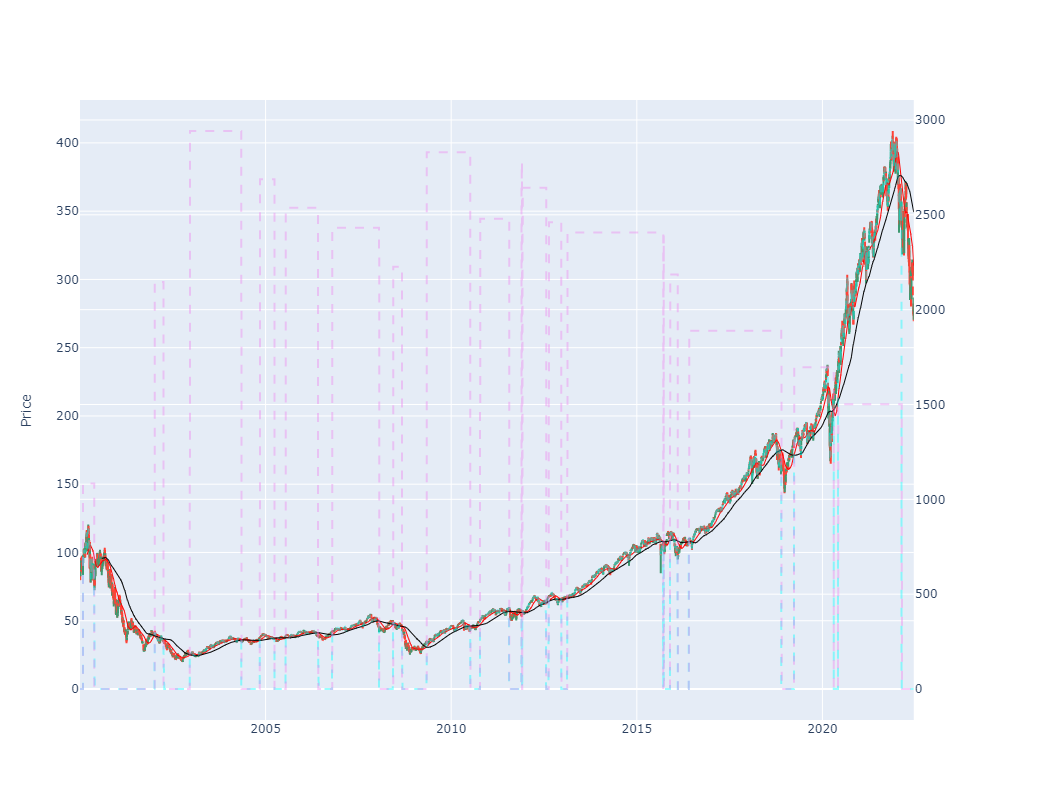

In [66]:
fig = make_subplots(specs=[[{"secondary_y":True}]])

fig.add_trace(go.Ohlc(
    name="price",
    x=df.index, open=df.O, high=df.H, low=df.L, close=df.C,
    xhoverformat='%Y-%m-%d'),secondary_y = False)
fig.add_trace(go.Scatter(name="ma" + str(short_MA),x=df.index,y=df[f"{str(short_MA)}dSMA"],line={'color': 'red', 'width': 1}),secondary_y=False)
fig.add_trace(go.Scatter(name="ma" + str(long_MA),x=df.index,y=df[f"{str(long_MA)}dSMA"],line={'color': 'black', 'width': 1}),secondary_y=False)

fig.add_trace(go.Scatter(name='pos',x = df.index,y = df.pos,line_color='violet',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.4),
              secondary_y = True)
# fig.add_trace(go.Scatter(name='balance',x = df.index,y = df.balance,line_color='orange',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.6),
#               secondary_y = False)



fig.add_trace(go.Scatter(name=entry_signal.name,x=df.index,y=df.es,line_color='cyan',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.4),
              secondary_y = False)

fig.update_layout(autosize=False, 
                  width=2000,
                  height=800,
                  title="",
                  yaxis_title="Price",
                  xaxis_rangeslider_visible=False,
                  showlegend=False,
                 hovermode='x unified')
fig.show()

### Equity Curve

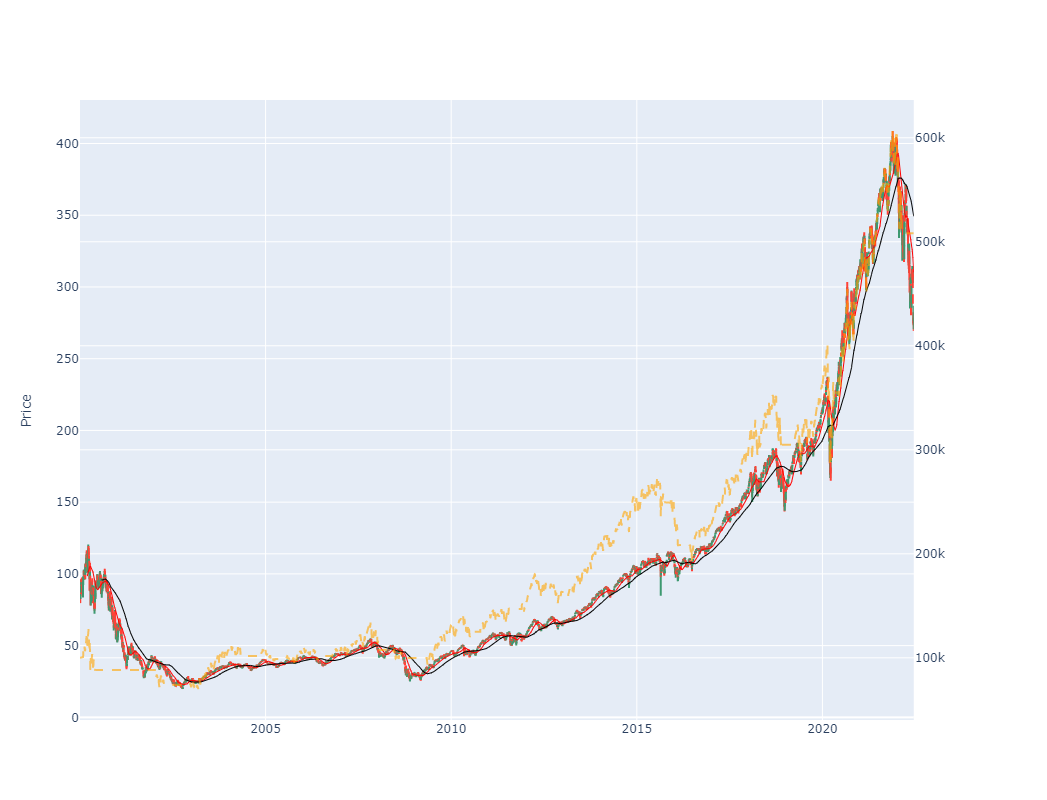

In [67]:
df['balance'] = df.cash + df.pos * df.C

fig = make_subplots(specs=[[{"secondary_y":True}]])

fig.add_trace(go.Ohlc(
    name="price",
    x=df.index, open=df.O, high=df.H, low=df.L, close=df.C,
    xhoverformat='%Y-%m-%d'),secondary_y = False)
fig.add_trace(go.Scatter(name="ma" + str(short_MA),x=df.index,y=df[f"{str(short_MA)}dSMA"],line={'color': 'red', 'width': 1}),secondary_y=False)
fig.add_trace(go.Scatter(name="ma" + str(long_MA),x=df.index,y=df[f"{str(long_MA)}dSMA"],line={'color': 'black', 'width': 1}),secondary_y=False)

fig.add_trace(go.Scatter(name='balance',x = df.index,y = df.balance,line_color='orange',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.6),
              secondary_y = True)

fig.update_layout(autosize=False, 
                  width=2000,
                  height=800,
                  title="",
                  yaxis_title="Price",
                  xaxis_rangeslider_visible=False,
                  showlegend=False,
                 hovermode='x unified')
fig.show()

### Visualize Trades

In [68]:
trades = pd.read_csv(os.path.join(out_dir,f'trades_{ticker}_{name}.csv'),index_col=0,header=0)
trades.sort_values('entry_date', ascending=True, inplace=True)
trades

ticker  entry_date  entry_price   shares   exit_date  exit_price  \
0     QQQ  2000-02-02        92.25 1,084.01  2000-05-23       81.38   
1     QQQ  2002-01-08        41.10 2,146.26  2002-04-04       34.50   
2     QQQ  2002-12-19        25.17 2,941.84  2004-05-10       34.67   
3     QQQ  2004-11-08        37.95 2,687.58  2005-03-31       36.73   
4     QQQ  2005-07-19        38.91 2,537.00  2006-06-02       39.96   
5     QQQ  2006-10-19        41.69 2,431.72  2008-01-24       44.19   
6     QQQ  2008-06-10        48.27 2,226.18  2008-09-04       44.86   
7     QQQ  2009-05-06        35.29 2,829.88  2010-07-09       44.18   
8     QQQ  2010-10-13        50.43 2,479.16  2011-07-26       59.44   
9     QQQ  2011-11-25        53.06 2,777.26  2011-11-29       54.69   
10    QQQ  2011-12-05        57.47 2,642.92  2012-07-24       63.57   
11    QQQ  2012-08-20        68.27 2,460.97  2012-12-20       66.38   
12    QQQ  2013-02-19        67.88 2,406.58  2015-09-18      105.23   
13    QQQ  2015-09-21       105.93 2,390.68  2015-09-23      104.38   
14    QQQ  2015-11-25       114.22 2,184.73  2016-02-09       95.33   
15    QQQ  2016-05-31       110.28 1,888.55  2018-11-26      161.44   
16    QQQ  2019-03-29       179.69 1,696.75  2020-04-22      209.10   
17    QQQ  2020-06-04       236.33 1,501.25  2022-02-22      338.49   

                                             memo        pnl  pnl_pcnt  \
0   bought-50dMAAbove150MA / sold-50dMABelow150MA -11,788.62     -0.12   
1   bought-50dMAAbove150MA / sold-50dMABelow150MA -14,165.33     -0.16   
2   bought-50dMAAbove150MA / sold-50dMABelow150MA  27,947.45      0.38   
3   bought-50dMAAbove150MA / sold-50dMABelow150MA  -3,278.85     -0.03   
4   bought-50dMAAbove150MA / sold-50dMABelow150MA   2,663.85      0.03   
5   bought-50dMAAbove150MA / sold-50dMABelow150MA   6,079.31      0.06   
6   bought-50dMAAbove150MA / sold-50dMABelow150MA  -7,591.28     -0.07   
7   bought-50dMAAbove150MA / sold-50dMABelow150MA  25,157.65      0.25   
8   bought-50dMAAbove150MA / sold-50dMABelow150MA  22,337.25      0.18   
9   bought-50dMAAbove150MA / sold-50dMABelow150MA   4,526.93      0.03   
10  bought-50dMAAbove150MA / sold-50dMABelow150MA  16,121.78      0.11   
11  bought-50dMAAbove150MA / sold-50dMABelow150MA  -4,651.23     -0.03   
12  bought-50dMAAbove150MA / sold-50dMABelow150MA  89,885.93      0.55   
13  bought-50dMAAbove150MA / sold-50dMABelow150MA  -3,705.56     -0.01   
14  bought-50dMAAbove150MA / sold-50dMABelow150MA -41,269.45     -0.17   
15  bought-50dMAAbove150MA / sold-50dMABelow150MA  96,618.48      0.46   
16  bought-50dMAAbove150MA / sold-50dMABelow150MA  49,901.31      0.16   
17  bought-50dMAAbove150MA / sold-50dMABelow150MA 153,367.34      0.43   

          hp  
0   111 days  
1    86 days  
2   508 days  
3   143 days  
4   318 days  
5   462 days  
6    86 days  
7   429 days  
8   286 days  
9     4 days  
10  232 days  
11  122 days  
12  941 days  
13    2 days  
14   76 days  
15  909 days  
16  390 days  
17  628 days

### Review Performance Statistics

In [69]:
trades = pd.read_csv(os.path.join(out_dir,f'stats_{ticker}_{name}.csv'),index_col=0,header=0)
trades

stats
no_trades                                        18
no_winning_trades                                11
no_losing_trades                                  7
win/loss ratio                                 0.61
EV                                             0.11
avg_winning_pnl_pcnt                           0.24
avg_losing_pnl_pcnt                           -0.08
r                                               3.0
min_pnl_pcnt                                  -0.17
max_pnl_pcnt                                   0.55
avg_hp                            318 days 12:00:00
avg_winning_hp          464 days 06:32:43.636363640
avg_losing_hp            89 days 10:17:08.571428571
total_pnl                                 408156.97
time_span                        8346 days, 0:00:00
cagr                            0.07368225678889795
max_dd_pcnt_realized            0.17759498446279967
max_dd_pcnt_unrealized           0.4514690924654793

## Conclusion

Using short/long term moving averages to distinguish between uptrends and downtrends reduces the maximum drawdown and improves the CAGR for most reasonable choices of short MA (2d=price, 10d,21d,50d) and long term MA (21d, 50d, 150d and 200d). 

The best results are achieved in two cases: 
- **ST=50d, LT=150d**. In this case, CAGR=7.4%, DD=45%, holding period is 464d for winning trades and 89d for losing trades. P=0.61, W=24% and L=8%. This seems to be a good approach - one weakness is that it misses very fast moves (like Covid) but works very well in normal conditions. For very fast moves, it may be necessary to use shorter-term indicators (O'Neil or just exit after a few bad days).  
- **ST=2d, LT=150d**. CAGR=7.2%, DD=55%. In this caase, holding period is 190d for winning trades, 22d for losing trades. P=0.4, W=13% and L=3%. 

Using shorter MAs results in earlier entries/exits for larger moves but introduces short-term trades in bear market rallies and choppy markets which tend to be losing trades and negate the benefits of earlier entry/exits. 

This is a two state strategy which was described in The Turtle System. 

Two questions: 
- Would a two-state strategy work on a single stock (e.g., OKTA as a typical S1-S2-S3-S4 stock, TTD as similar with high vol, S


